In [1]:
# pip install cvxpy openpyxl ecos scs

In [2]:
import re, numpy as np, pandas as pd, cvxpy as cp
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

### Liabilities

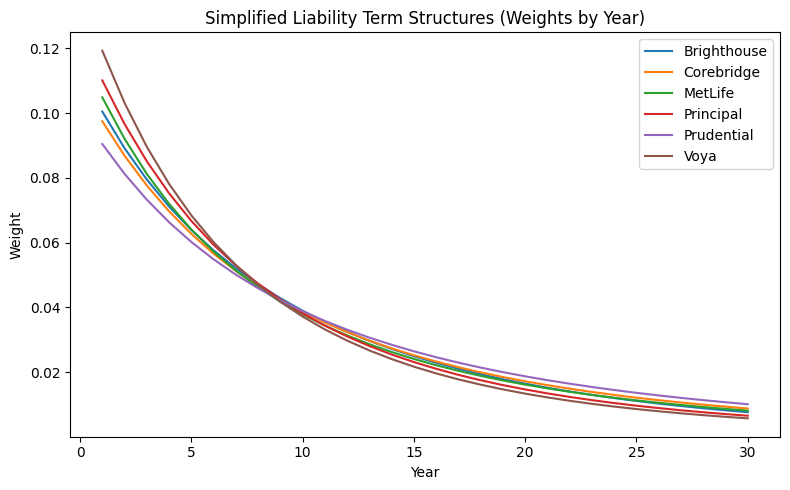

'Liability_Profiles.xlsx'

In [3]:
T = 30
years = np.arange(1, T + 1)

# --- Bucket duration presets (years) ---
# Keep these simple and consistent; you can tweak per company if desired.
bucket_durations_default = {
    "Short": 4.0,
    "Medium": 8.0,
    "Long": 20.0,
}

# --- Company-specific mixes (weights must sum to 1) ---
# These are intentionally simple and aligned with each company's product mix:
# - More "retirement / VA hedging" -> more Medium, some Short
# - More "ULSG / payout annuities"  -> more Long
# - More "group benefits / stable value" -> more Short
company_bucket_weights = {
    "Brighthouse": {"Short": 0.10, "Medium": 0.45, "Long": 0.45},
    "Corebridge":  {"Short": 0.15, "Medium": 0.55, "Long": 0.30},
    "MetLife":     {"Short": 0.25, "Medium": 0.50, "Long": 0.25},
    "Principal":   {"Short": 0.20, "Medium": 0.60, "Long": 0.20},
    "Prudential":  {"Short": 0.15, "Medium": 0.45, "Long": 0.40},
    "Voya":        {"Short": 0.30, "Medium": 0.55, "Long": 0.15},
}

# Optionally tweak bucket durations per company (keep it very minor/simple)
company_bucket_durations = {
    "Brighthouse": {"Short": 3.0, "Medium": 7.0, "Long": 15.0},
    "Corebridge":  {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "MetLife":     {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "Principal":   {"Short": 4.0, "Medium": 8.0, "Long": 18.0},
    "Prudential":  {"Short": 4.0, "Medium": 8.0, "Long": 20.0},
    "Voya":        {"Short": 4.0, "Medium": 8.0, "Long": 18.0},
}

def make_liability_curve(weights, durations, years):
    """
    Exponential-decay blend:
        CF_t ∝ sum_b [ w_b * exp(-t / D_b) ]
    Then normalize so weights sum to 1 across t=1..T.
    """
    curve = np.zeros_like(years, dtype=float)
    for b, w in weights.items():
        D = durations[b]
        curve += w * np.exp(-years / D)
    curve /= curve.sum()
    return curve

# Build curves and summary metrics
records = []
summary_rows = []
curves = {}

for company, wts in company_bucket_weights.items():
    durs = company_bucket_durations.get(company, bucket_durations_default)
    curve = make_liability_curve(wts, durs, years)
    curves[company] = curve

    # Simple "Macaulay-like" stats on the discrete weights (no discount curve applied here)
    duration_years = float(np.sum(curve * years))
    convexity = float(np.sum(curve * (years ** 2)))  # rough proxy (unscaled)

    # Liquidity metrics (share of total CF in first 1y / 5y)
    liq_1y = float(curve[0])  # year 1 weight
    liq_5y = float(np.sum(curve[:5]))

    # Save per-year records
    for t, wt in zip(years, curve):
        records.append({"Company": company, "Year": t, "Liability_Weight": wt})

    summary_rows.append({
        "Company": company,
        "Avg_Duration_yrs": duration_years,
        "Convexity_proxy": convexity,
        "Share_1Y": liq_1y,
        "Share_5Y": liq_5y,
        "Short_wt": wts["Short"],
        "Medium_wt": wts["Medium"],
        "Long_wt": wts["Long"],
        "Short_D": durs["Short"],
        "Medium_D": durs["Medium"],
        "Long_D": durs["Long"],
    })

df_curves = pd.DataFrame(records)
df_summary = pd.DataFrame(summary_rows).set_index("Company")

# Plot all six curves on one chart (each line is the per-year weight)
plt.figure(figsize=(8, 5))
for company, curve in curves.items():
    plt.plot(years, curve, label=company)
plt.title("Simplified Liability Term Structures (Weights by Year)")
plt.xlabel("Year")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()

# Build an Excel workbook with:
# - Assumptions sheet (bucket weights & durations)
# - LiabilityCurves sheet (per company, per year weights)
# - Summary sheet (duration, convexity proxy, liquidity shares)
assumptions_rows = []
for company in company_bucket_weights:
    row = {"Company": company}
    row.update({f"BucketWeight_{k}": v for k, v in company_bucket_weights[company].items()})
    row.update({f"BucketDur_{k}": v for k, v in company_bucket_durations[company].items()})
    assumptions_rows.append(row)
df_assumptions = pd.DataFrame(assumptions_rows).set_index("Company")

excel_path = "Liability_Profiles.xlsx"
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    df_assumptions.to_excel(writer, sheet_name="Assumptions")
    df_curves.pivot(index="Year", columns="Company", values="Liability_Weight").to_excel(writer, sheet_name="LiabilityCurves")
    df_summary.to_excel(writer, sheet_name="Summary")

excel_path

In [4]:
EXCEL_PATH = "final_inputs.xlsx"
SHEET_NAME = 0
RISK_FREE = 0.04
N_FRONTIER_POINTS = 200
DUR_TARGET = 6.0
DUR_TOL = 1.0
LIQUID_MIN = None
W_MIN_DEFAULT = 0.00
W_MAX_DEFAULT = 0.10
LIABILITY_BOOK_PATH = "Liability_Profiles.xlsx"
LIABILITY_COMPANY = None
KRD_TOL = 0.10
KEY_BUCKETS = {"KR1": (0,3), "KR5": (3,7), "KR10": (7,12), "KR20": (12,25), "KR30": (25,40)}

### Brighthouse

In [ ]:
def nearest_psd(A, eps=1e-10):
    B = 0.5 * (A + A.T)
    vals, vecs = np.linalg.eigh(B)
    vals_clipped = np.maximum(vals, eps)
    return vecs @ np.diag(vals_clipped) @ vecs.T

def rating_to_numeric_fixed(rating):
    """Returns rating score only for fixed income assets, None for others"""
    scale = {
        "AAA": 1, "AA+": 2, "AA": 3, "AA-": 4,
        "A+": 5, "A": 6, "A-": 7,
        "BBB+": 8, "BBB": 9, "BBB-": 10,
        "BB+": 11, "BB": 12, "BB-": 13,
        "B+": 14, "B": 15, "B-": 16,
        "CCC": 17, "CC": 18, "C": 19
    }
    rating_str = str(rating).strip()
    if rating_str in scale:
        return scale[rating_str]
    else:
        return None  # No rating = not fixed income

def load_inputs(path, sheet=0):
    df = pd.read_excel(path, sheet_name=sheet).dropna(how="all")
    assets = df.iloc[:, 0].astype(str).values
    ratings = df.iloc[:, 1].astype(str).values
    mu = df.iloc[:, 2].astype(float).values
    cap_charge = df.iloc[:, 3].astype(float).values
    sigma_ref = df.iloc[:, 4].astype(float).values
    duration = df.iloc[:, 5].astype(float).fillna(0.0).values
    brighthouse_alloc = df.iloc[:, 6].astype(float).values
    corebridge_alloc = df.iloc[:, 7].astype(float).values
    metlife_alloc = df.iloc[:, 8].astype(float).values
    principal_alloc = df.iloc[:, 9].astype(float).values
    prudential_alloc = df.iloc[:, 10].astype(float).values
    voya_alloc = df.iloc[:, 11].astype(float).values
    n = len(assets)
    cov = df.iloc[:, 12:12+n].astype(float).values
    if cov.shape != (n, n):
        raise ValueError(f"Covariance must be {n}x{n}, got {cov.shape}")
    S = nearest_psd(0.5 * (cov + cov.T))
    
    # Package company allocations into a dictionary
    company_allocations = {
        'Brighthouse': brighthouse_alloc,
        'Corebridge': corebridge_alloc,
        'MetLife': metlife_alloc,
        'Principal': principal_alloc,
        'Prudential': prudential_alloc,
        'Voya': voya_alloc
    }
    
    return assets, ratings, mu, sigma_ref, duration, S, company_allocations

def load_liability_profiles(path="Liability_Profiles.xlsx"):
    """Load liability duration profiles for all companies"""
    df_summary = pd.read_excel(path, sheet_name="Summary", index_col=0)
    return df_summary

def add_liability_duration_constraint(constraints, w, duration, company_liability_duration):
    """Add asset-liability duration mismatch constraint (±1 year)"""
    portfolio_duration = duration @ w
    liability_duration = company_liability_duration
    
    # Asset-liability mismatch should not exceed ±1 year
    constraints += [portfolio_duration >= liability_duration - 1.0]
    constraints += [portfolio_duration <= liability_duration + 1.0]
    
    return constraints

def solve_min_variance_corrected(mu, S, duration, target_mu, wmin, wmax, assets, ratings, rating_scores, company_liability_duration):
    """Min-variance optimization with ±1 year duration constraint"""
    n = len(mu)
    w = cp.Variable(n)
    w_equal = np.ones(n) / n
    lambda_conc = 0.005

    # MODIFIED OBJECTIVE: Minimize variance + concentration penalty
    objective = cp.quad_form(w, S) + lambda_conc * cp.sum_squares(w - w_equal)
    
    # Basic constraints
    constraints = [
        cp.sum(w) == 1,
        w >= wmin,
        w <= wmax,
        mu @ w >= target_mu,
        # CORRECTED: ±1 year liability duration constraint
        duration @ w >= company_liability_duration - 1.0,
        duration @ w <= company_liability_duration + 1.0
    ]
    
    # Credit quality constraint
    has_rating = np.array([score is not None for score in rating_scores])
    if has_rating.any():
        rated_weights = w[has_rating]
        rated_scores_array = np.array([score for score in rating_scores if score is not None])
        total_rated_weight = cp.sum(rated_weights)
        constraints += [rated_scores_array @ rated_weights <= 5 * total_rated_weight]
    
    # Rating limits
    rating_map = dict(zip(assets, ratings))
    is_bbb = np.array([rating_map[a] == "BBB" for a in assets])
    is_below_ig = np.array([rating_map[a] in {"BB", "BB-", "B+", "B", "B-", "CCC"} for a in assets])
    
    constraints += [
        cp.sum(w[is_bbb]) <= 0.15,
        cp.sum(w[is_below_ig]) <= 0.05
    ]
    
    is_equity = np.array(["Private Equity" in a for a in assets])
    is_hy_loans = np.array(["Leveraged Loans" in a for a in assets])
    is_emd_ig = np.array(["ex-US" in a for a in assets])
    is_real_estate = np.array(["Real Estate" in a for a in assets])
    is_cml = np.array([
        "Residential Mortgage Whole Loans" in a or "Commercial Mortgage Whole Loans" in a for a in assets
    ])
    is_direct_lending = np.array(["Direct Lending" in a for a in assets])
    is_alternatives = np.array(["Alternatives" in a or "Special Situation" in a for a in assets])
    is_strategic = is_equity | is_hy_loans | is_emd_ig | is_real_estate | is_cml | is_direct_lending | is_alternatives

    constraints += [cp.sum(w[is_equity]) <= 0.05]
    constraints += [cp.sum(w[is_hy_loans]) <= 0.05]
    constraints += [cp.sum(w[is_emd_ig]) <= 0.10]
    constraints += [cp.sum(w[is_real_estate]) <= 0.05]
    constraints += [cp.sum(w[is_cml]) <= 0.20]
    constraints += [cp.sum(w[is_direct_lending]) <= 0.20]
    constraints += [cp.sum(w[is_alternatives]) <= 0.05]
    constraints += [cp.sum(w[is_strategic]) <= 0.35]
    
    # Solve
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status in ("optimal", "optimal_inaccurate"):
        return w.value, float(w.value @ S @ w.value), float(mu @ w.value)
    return None

In [14]:
def optimize_brighthouse(show_plots=True, export_excel=False):
    # Load data
    assets, ratings, mu, sigma_ref, duration, Sigma, company_allocations = load_inputs(EXCEL_PATH, SHEET_NAME)
    current_alloc = company_allocations['Brighthouse']  # Get Brighthouse current allocation
    liability_profiles = load_liability_profiles()
    company_liability_duration = liability_profiles.loc["Brighthouse", 'Avg_Duration_yrs']
    n = len(assets)
    wmin, wmax = np.full(n, W_MIN_DEFAULT), np.full(n, W_MAX_DEFAULT)
    rating_scores = np.array([rating_to_numeric_fixed(r) for r in ratings])

    print(f"Brighthouse Optimization - Liability Duration: {company_liability_duration:.1f} years")
    print(f"Required duration range: {company_liability_duration-1:.1f} to {company_liability_duration+1:.1f} years\n")

    # Build efficient frontier
    targets = np.linspace(max(mu.min(), np.percentile(mu, 15)), mu.max(), N_FRONTIER_POINTS)
    frontier_pts, frontier_wts = [], []

    for target_mu in targets:
        sol = solve_min_variance_corrected(mu, Sigma, duration, target_mu, wmin, wmax, 
                                           assets, ratings, rating_scores, company_liability_duration)
        if sol:
            w_opt, var, ret = sol
            frontier_pts.append((ret, np.sqrt(var)))
            frontier_wts.append(w_opt)

    if not frontier_pts:
        print("✗ No feasible portfolios found with ±1 year duration constraint")
        return None

    # Select 6 risk-dispersed portfolios
    frontier_data = [(ret, vol, i) for i, (ret, vol) in enumerate(frontier_pts)]
    frontier_data.sort(key=lambda x: x[1])
    target_vols = np.linspace(frontier_data[0][1], frontier_data[-1][1], 6)
    selected_indices = []
    for target_vol in target_vols:
        idx = min(frontier_data, key=lambda x: abs(x[1] - target_vol))[2]
        if idx not in selected_indices:
            selected_indices.append(idx)
    while len(selected_indices) < 6 and len(selected_indices) < len(frontier_pts):
        for _, _, idx in frontier_data:
            if idx not in selected_indices:
                selected_indices.append(idx)
                break

    # Max Sharpe portfolio
    max_sharpe_idx = max(range(len(frontier_pts)), key=lambda i: (frontier_pts[i][0] - RISK_FREE) / frontier_pts[i][1])
    portfolio_names = ['Port A', 'Port B', 'Port C', 'Port D', 'Port E', 'Port F', 'Max Sharpe']
    all_indices = selected_indices[:6] + [max_sharpe_idx]

    def calc_avg_rating(weights, ratings_arr, rating_scores_arr):
        has_rating = np.array([score is not None for score in rating_scores_arr])
        if not has_rating.any(): return None
        fi_weights = weights[has_rating]
        fi_scores = np.array([score for score in rating_scores_arr if score is not None])
        total_weight = fi_weights.sum()
        if total_weight < 0.01: return None
        avg_score = (fi_weights @ fi_scores) / total_weight
        rating_map = {1: "AAA", 2: "AA+", 3: "AA", 4: "AA-", 5: "A+", 6: "A", 7: "A-", 8: "BBB+", 9: "BBB", 10: "BBB-",
                      11: "BB+", 12: "BB", 13: "BB-", 14: "B+", 15: "B", 16: "B-", 17: "CCC+"}
        return rating_map.get(round(avg_score), f"~{avg_score:.1f}")

    # Compile results - START WITH CURRENT PORTFOLIO
    results_data = {}
    
    # Add Current portfolio first
    current_ret = mu @ current_alloc
    current_vol = np.sqrt(current_alloc @ Sigma @ current_alloc)
    current_sharpe = (current_ret - RISK_FREE) / current_vol if current_vol > 0 else 0
    current_dur = duration @ current_alloc
    
    results_data['Current'] = {
        'Expected Return (%)': current_ret * 100,
        'Risk (%)': current_vol * 100,
        'Sharpe Ratio': current_sharpe,
        'Avg FI Credit Rating': calc_avg_rating(current_alloc, ratings, rating_scores),
        'FI Duration (years)': current_dur,
        'Net Duration (years)': current_dur - company_liability_duration
    }
    for a, weight in zip(assets, current_alloc):
        results_data['Current'][a] = weight * 100
    
    # Add optimized portfolios
    for name, idx in zip(portfolio_names, all_indices):
        w = frontier_wts[idx]
        ret, vol = frontier_pts[idx]
        sharpe = (ret - RISK_FREE) / vol
        port_dur = duration @ w
        results_data[name] = {
            'Expected Return (%)': ret * 100,
            'Risk (%)': vol * 100,
            'Sharpe Ratio': sharpe,
            'Avg FI Credit Rating': calc_avg_rating(w, ratings, rating_scores),
            'FI Duration (years)': port_dur,
            'Net Duration (years)': port_dur - company_liability_duration
        }
        for a, weight in zip(assets, w):
            results_data[name][a] = weight * 100

    df_results = pd.DataFrame(results_data)

    # Display combined table
    print("="*120)
    print("PORTFOLIO COMPARISON TABLE")
    print("="*120)
    
    # Prepare combined table
    summary_metrics = ['Expected Return (%)', 'Risk (%)', 'Sharpe Ratio', 
                      'Avg FI Credit Rating', 'FI Duration (years)', 'Net Duration (years)']
    
    # Create combined display DataFrame
    df_combined = df_results.copy()
    
    # Apply formatting
    df_combined_display = df_combined.copy()
    
    # Format summary metrics (2 decimals for precision)
    for metric in summary_metrics:
        if metric == 'Avg FI Credit Rating':
            continue  # Keep as string
        else:
            for col in df_combined_display.columns:
                val = df_combined_display.loc[metric, col]
                if not pd.isna(val) and not isinstance(val, str):
                    formatted = f'{float(val):.2f}'
                    if formatted == '-0.00':
                        formatted = '0.00'
                    df_combined_display.loc[metric, col] = formatted
    
    # Format asset allocations (1 decimal, no % sign)
    asset_rows = [row for row in df_combined_display.index if row not in summary_metrics]
    for asset in asset_rows:
        for col in df_combined_display.columns:
            val = df_combined_display.loc[asset, col]
            if not pd.isna(val):
                formatted = f'{float(val):.1f}'
                if formatted == '-0.0':
                    formatted = '0.0'
                df_combined_display.loc[asset, col] = formatted
    
    # Show ALL assets
    final_rows = summary_metrics + asset_rows  # Show all 21 assets
    df_final = df_combined_display.loc[final_rows]
    
    # SUBTLE STYLING with gentle gradient
    styled_table = df_final.style
    
    # Apply subtle gradient to asset allocation rows only
    styled_table = styled_table.background_gradient(cmap='Blues', axis=None, 
                                                   subset=pd.IndexSlice[asset_rows, :],
                                                   vmin=0, vmax=15)  # Cap at 15% for better contrast
    
    display(styled_table)

    if export_excel:
        with pd.ExcelWriter("Brighthouse_Portfolio_Analysis.xlsx") as writer:
            df_results.to_excel(writer, sheet_name='Full_Results')
            df_final.to_excel(writer, sheet_name='Formatted_Display')
            df_results.loc[summary_metrics].to_excel(writer, sheet_name='Summary_Metrics')
        print("\n✓ Results exported to: Brighthouse_Portfolio_Analysis.xlsx")

    if show_plots:
        rets, sigmas = zip(*frontier_pts)
        plt.figure(figsize=(12, 7))
        plt.plot(sigmas, rets, 'b-', alpha=0.3, label="Efficient Frontier")
        
        # Plot Current portfolio
        plt.scatter([current_vol], [current_ret], s=200, c='black', marker='D', 
                   edgecolors='white', linewidths=2, label='Current', zorder=5)
        
        # Plot optimized portfolios
        colors = ['green', 'blue', 'purple', 'orange', 'brown', 'pink']
        for name, idx, color in zip(portfolio_names[:-1], selected_indices[:6], colors):
            r, v = frontier_pts[idx]
            plt.scatter([v], [r], s=150, c=color, marker='o', edgecolors='black', label=name)
        r_ms, v_ms = frontier_pts[max_sharpe_idx]
        plt.scatter([v_ms], [r_ms], s=400, c='red', marker='*', edgecolors='black', label='Max Sharpe')
        plt.xlabel("Volatility (%)"); plt.ylabel("Expected Return (%)")
        plt.title("Brighthouse Efficient Frontier - Portfolio Selection", fontsize=14, fontweight='bold')
        plt.legend(loc='best'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    return df_results

In [15]:
# Run the comprehensive analysis
results_df = optimize_brighthouse()

ValueError: not enough values to unpack (expected 7, got 6)